In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
"""
코드 : https://github.com/u7javed/Conditional-WGAN-GP/blob/master/train.py
"""
import numpy as np
import pandas as pd
import time

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print('Using device:', device)

Using device: cpu


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성

In [3]:
# LAB 데이터상의 JRCODE 리스트 생성
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

# LAB 데이터상의 전체 원재료코드(JRCODE) 및 분류(MIXDSCD) 고유 리스트 생성
lab_JRCODE_ls = []
lab_MIXDSCD_ls = []
for yCol in yCols:
    data = pd.read_csv(f'./dataset/data_{yCol}.csv')
    lab_JRCODE_ls += data['lar_cd'].unique().tolist()
    lab_MIXDSCD_ls += data['mix_ds_cd'].unique().tolist()

lab_JRCODE_ls = list(set(lab_JRCODE_ls))
lab_MIXDSCD_ls = list(set(lab_MIXDSCD_ls))

# MES 데이터상의 JRCODE 리스트 생성
sfites_RMixSub1_full = pd.read_csv(f'./dataset/sfites_RMixSub1_full.csv')
mes_JRCODE_ls = sfites_RMixSub1_full['JRCODE'].unique().tolist()

# LAB/MES JRCODE 통합
JRCODE_ls = list(set(mes_JRCODE_ls + lab_JRCODE_ls))
print(f'LAB JRCODE : {len(lab_JRCODE_ls)}, MES JRCODE : {len(mes_JRCODE_ls)}, LAB MIAXDSCD : {len(lab_MIXDSCD_ls)}')

# 원재료코드 JRCODE 값의 숫자로 인코딩
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index + 1

# JRCODE_df['MCODE'] = JRCODE_df['JRCODE'].str[:1]
# JRCODE_df['DCODE'] = JRCODE_df['JRCODE'].str[:2]
# mcode_num = JRCODE_df['MCODE'].nunique()
# dcode_num = JRCODE_df['DCODE'].nunique()
# print(f'중분류 수 : {mcode_num}, 소분류 수 : {dcode_num} 전체 49개!')

JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 분류 MIXDSCD 값의 숫자로 인코딩
MIXDSCD_df = pd.DataFrame({'MIXDSCD':lab_MIXDSCD_ls}).sort_values('MIXDSCD').reset_index(drop=True)
MIXDSCD_df['MIXDSCD_ID'] = MIXDSCD_df.index + 1

# 공정종류 PUTGB 값의 숫자로 인코딩
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F','M','MIX','SCRAP','DUMP']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1

print(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

display(JRCODE_df.head(), PUTGB_df.head())

JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

MIXDSCD_dict = {}
for idx, row in MIXDSCD_df.iterrows():
    MIXDSCD_dict[row['MIXDSCD']] = row['MIXDSCD_ID']

PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 처음으로 추가
JRCODE_dict[np.nan] = 0
MIXDSCD_dict[np.nan] = 0
PUTGB_dict[np.nan] = 0

# # nan을 마지막으로 추가
# # 이 경우, 위에 인덱스 값을 그대로 사용
# JRCODE_dict[np.nan] = len(JRCODE_dict)+1
# MIXDSCD_dict[np.nan] = len(MIXDSCD_dict)+1
# PUTGB_dict[np.nan] = len(PUTGB_dict)+1

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}, LAB MIXDSCD 딕셔너리 길이: {len(MIXDSCD_dict)}')

LAB JRCODE : 458, MES JRCODE : 1045, LAB MIAXDSCD : 4
전체 원재료코드 수 : 1409, 공정종류 수 : 10


,JRCODE,JR_ID
0,CA001,1
1,CA0011,2
2,CA001B,3
3,CA002,4
4,CA002A,5


,PUTGB,PUTGB_ID
0,P,1
1,CH,2
2,CB,3
3,OA,4
4,OB,5


'NAN포함!! JRCODE 딕셔너리 길이: 1410, PUTGB 딕셔너리 길이: 11, LAB MIXDSCD 딕셔너리 길이: 5'

In [49]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 64),            
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, input_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 64),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm1d(64),
            nn.Linear(64, output_size),
        )
    
    def forward(self, x):
        return self.model(x)
    
# For checking CGAN's validity in final step
def check_condition(_generator, sample_num, target_label, condition_size, latent_size):
    test_label = torch.full((1, sample_num), target_label).squeeze(0)
    test_label_encoded = F.one_hot(test_label, num_classes=condition_size)#.to(device)

    # create noise(latent vector) 'z'
    _z = torch.randn(sample_num, latent_size)#.to(device)
    _z_concat = torch.cat((_z, test_label_encoded), 1)
    generated_data = _generator(_z_concat)

    return generated_data.detach()

def gradient_penalty(discriminator, real_samples, fake_samples, label_encoded):
        # Random weight term for interpolation between real and fake samples
        # alpha = tf.random.normal([real.shape[0], 1], 0.0, 1.0)
        alpha = torch.Tensor(np.random.random((fake_samples.size(0), 1)))#.to(device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = discriminator(torch.cat((interpolates, label_encoded), 1))
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0)#.to(device)
        fake.requires_grad = False
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )
        gradients = gradients[0].view(gradients[0].size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

        # # Random weight term for interpolation between real and fake samples
        # alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))#.to(device)
        # # Get random interpolation between real and fake samples
        # interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        # print(interpolates.shape)
        # print(interpolates)
        # d_interpolates = discriminator(interpolates, labels)
        # fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(device)
        # fake.requires_grad = False
        # # Get gradient w.r.t. interpolates
        # gradients = torch.autograd.grad(
        #     outputs=d_interpolates,
        #     inputs=interpolates,
        #     grad_outputs=fake,
        #     create_graph=True,
        #     retain_graph=True,
        #     only_inputs=True,
        # )
        # gradients = gradients[0].view(gradients[0].size(0), -1)
        # gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        # return gradient_penalty

In [43]:
batch_size = 64
lr = 0.00005
gp_weight = 5

num_epochs = 300
show_step = 25
latent_size_ = 50

stVal = 0

criterion = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[:1]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')

    # 조건변수의 구간화
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = nUniq//10
    print(f'groupNum : {grNum}')

    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)
    # data_df[yCol+'_G'], cutBins = pd.cut(data_df[yCol],bins=grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)

    # 원재료코드의 숫자로의 인코드
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        data_df['phr'+str(i)].fillna(0, inplace=True)

    # 분류의 숫자로의 인코드
    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))

    # 필요없는 변수 제거
    data_df = data_df.drop(['lab_pk', yCol], axis=1)

    # batch_size 로 나눠지도록 나머지 버림
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    condition_size = grNum                                      # 조건 feature의 개수
    input_size = len(data_df.columns) - 1                       # 입력 feature의 개수
    output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
    latent_size = latent_size_                                  # 잠재 공간의 크기
    
    discriminator = Discriminator(input_size, condition_size)
    generator = Generator(latent_size, output_size, condition_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()

    gen_loss_trace = []
    dis_loss_trace = []
    was_loss_trace = []
    
    for epoch in range(num_epochs):

        gen_loss = 0
        dis_loss = 0

        for n, (real_data,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            real_data_labels = torch.ones((batch_size, 1))
            fake_data_labels = torch.zeros((batch_size, 1))

            real_data = real_data[:,:-1]
            labels = real_data[:,-1:]

            """
            FOR CONDITIONAL GAN
            """
            # Encode MNIST's label's with 'one hot encoding'
            label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
            # concat real images with 'label encoded vector'
            real_data_concat = torch.cat((real_data, label_encoded), 1)

            # +---------------------+
            # | train Discriminator |
            # +---------------------+

            # Initialize grad
            d_optimizer.zero_grad()

            # make fake images with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Calculate fake & real loss with generated images above & real images
            d_loss_fake = torch.mean(discriminator(fake_data_concat))
            d_loss_real = torch.mean(discriminator(real_data_concat))

            gp = gradient_penalty(discriminator, real_data, fake_data, label_encoded):

            # # Random weight term for interpolation between real and fake samples
            # # alpha = tf.random.normal([real.shape[0], 1], 0.0, 1.0)
            # alpha = torch.Tensor(np.random.random((fake_data.size(0), 1)))#.to(device)
            # # Get random interpolation between real and fake samples
            # interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
            # d_interpolates = discriminator(torch.cat((interpolates, label_encoded), 1))
            # fake = torch.Tensor(real_data_concat.shape[0], 1).fill_(1.0)#.to(device)
            # fake.requires_grad = False
            # # Get gradient w.r.t. interpolates
            # gradients = torch.autograd.grad(
            #     outputs=d_interpolates,
            #     inputs=interpolates,
            #     grad_outputs=fake,
            #     create_graph=True,
            #     retain_graph=True,
            #     only_inputs=True,
            # )
            # gradients = gradients[0].view(gradients[0].size(0), -1)
            # gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

            d_loss = d_loss_fake - d_loss_real
            was_loss = (d_loss_fake + d_loss_real) + gp_weight*gp
            was_loss.backward()
            d_optimizer.step()

            dis_loss += d_loss.item()/batch_size

            d_performance = discriminator(real_data_concat).mean()
            g_performance = discriminator(fake_data_concat).mean()

            # +---------------------+
            # |   train Generator   |
            # +---------------------+

            # Initialize grad
            g_optimizer.zero_grad()

            # make fake data with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Compare result of discriminator with fake images & real labels
            # If generator deceives discriminator, g_loss will decrease
            g_loss = -torch.mean(discriminator(fake_data_concat))

            # Train generator with backpropagation
            g_loss.backward()
            g_optimizer.step()

            gen_loss += g_loss.item()/batch_size

            p_d_real_trace.append(d_loss_real.item())
            p_d_gen_trace.append(d_loss_fake.item())
            p_g_gen_trace.append(g_loss.item())

        # Show loss
        if epoch % show_step == 0:
            print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, Loss W.: {was_loss:.5f}, time: {(time.time() - stTime):.3f}s")
            stTime = time.time()

        gen_loss_trace.append(gen_loss)
        dis_loss_trace.append(dis_loss)
        was_loss_trace.append(was_loss.item())

groupNum : 14
Epoch:   0 Loss D.: 0.38181, Loss G.: -0.84760, Loss W.: 5.55848, time: 0.567s
Epoch:  25 Loss D.: 0.31607, Loss G.: -0.31893, Loss W.: 5.16357, time: 14.148s
Epoch:  50 Loss D.: 0.02316, Loss G.: -0.02333, Loss W.: 5.01152, time: 14.894s
Epoch:  75 Loss D.: 0.00453, Loss G.: -0.00453, Loss W.: 5.00293, time: 13.929s
Epoch: 100 Loss D.: 0.00108, Loss G.: -0.00120, Loss W.: 5.00120, time: 13.698s
Epoch: 125 Loss D.: 0.00071, Loss G.: -0.00059, Loss W.: 5.00010, time: 13.560s
Epoch: 150 Loss D.: 0.00033, Loss G.: -0.00045, Loss W.: 5.00035, time: 13.710s
Epoch: 175 Loss D.: 0.00000, Loss G.: -0.00025, Loss W.: 5.00143, time: 13.797s
Epoch: 200 Loss D.: 0.00013, Loss G.: -0.00009, Loss W.: 5.00000, time: 13.868s
Epoch: 225 Loss D.: 0.00009, Loss G.: -0.00003, Loss W.: 5.00000, time: 13.786s
Epoch: 250 Loss D.: 0.00006, Loss G.: -0.00002, Loss W.: 5.00000, time: 13.773s
Epoch: 275 Loss D.: 0.00002, Loss G.: -0.00002, Loss W.: 5.00000, time: 13.731s


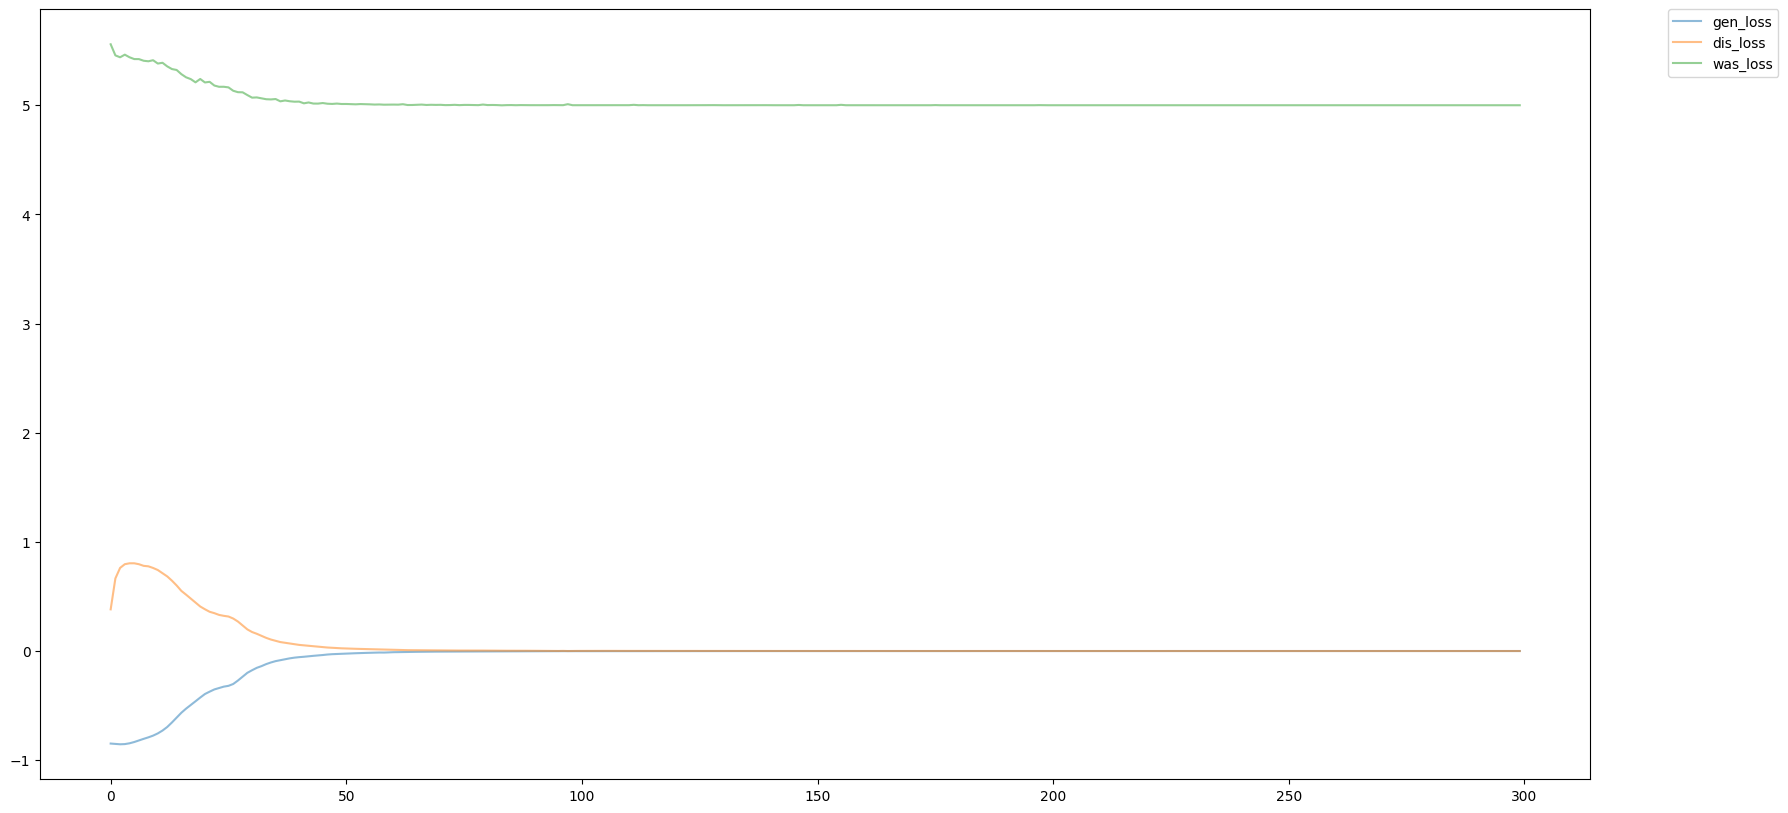

In [44]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(20,10))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(dis_loss_trace[sIdx:], label='dis_loss', alpha=0.5)
plt.plot(was_loss_trace[sIdx:], label='was_loss', alpha=0.5)
# plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [51]:
trg_label = 0
check_df = data_df[data_df[yCol+'_G']==trg_label]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.00000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,2.958589,164.432515,10.108896,616.707055,53.489350,465.180982,26.382331,160.009202,5.274983,109.91411,1.631635,225.857362,3.343324,455.340491,9.047709
std,1.002211,5.350974,1.453461,98.169413,33.153693,250.955693,26.829955,192.157897,11.264251,67.12756,3.597362,301.760609,10.676498,474.113146,19.090808
min,1.000000,160.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,160.000000,10.000000,576.000000,24.117621,81.000000,5.000000,78.000000,0.724026,78.00000,0.417758,98.000000,0.333333,115.000000,0.518135
50%,2.000000,160.000000,10.000000,581.000000,45.922802,564.000000,15.649163,81.000000,1.544640,93.00000,0.875904,115.000000,0.812458,180.000000,1.142857
75%,4.000000,170.000000,10.000000,679.000000,100.000000,585.000000,42.289157,93.000000,5.000000,98.00000,1.383367,180.000000,1.428571,1158.000000,6.598893
max,4.000000,180.000000,15.000000,856.000000,100.000000,871.000000,100.000000,856.000000,100.000000,419.00000,30.000000,1306.000000,100.000000,1386.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,-0.142889,0.188430,-0.422586,0.857532,-0.272488,-0.164539,0.370876,0.374295,-0.311357,-0.040346,0.263101,-0.442437,-0.341079,-0.091591,-0.110703
std,0.256497,0.207831,0.278600,0.319946,0.216855,0.268431,0.226541,0.246150,0.225464,0.272069,0.242902,0.276721,0.267329,0.296154,0.238174
min,-1.069650,-0.415275,-1.417244,-0.251334,-1.035249,-1.174120,-0.306331,-0.337824,-1.109135,-0.824595,-0.524129,-1.345043,-1.172711,-1.443672,-0.823746
25%,-0.311735,0.053732,-0.594459,0.650596,-0.422627,-0.338283,0.224917,0.211852,-0.457081,-0.228163,0.110328,-0.615675,-0.529407,-0.285282,-0.276416
50%,-0.131740,0.183906,-0.414419,0.841395,-0.273000,-0.164602,0.369341,0.379097,-0.313495,-0.034523,0.269739,-0.440369,-0.331976,-0.076460,-0.112537
75%,0.046583,0.336578,-0.227242,1.069193,-0.123132,0.022482,0.527037,0.532536,-0.164329,0.154996,0.419376,-0.252048,-0.162801,0.094810,0.055869
max,0.630896,0.821293,0.295474,1.845105,0.319529,0.700246,0.964409,1.365314,0.294537,0.815228,0.985073,0.265615,0.453336,0.707136,0.569749


In [ ]:
for trg_i in range(1, 4):
    trg_label = 4

    n_samples = len(check_df)
    gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
    gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
    # display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
    display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

In [182]:
batch_size = 64
lr = 0.005
num_epochs = 300
show_step = 25

stVal = 0

criterion = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[:1]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')

    # 조건변수의 구간화
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = nUniq//10
    print(f'groupNum : {grNum}')

    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)
    # data_df[yCol+'_G'], cutBins = pd.cut(data_df[yCol],bins=grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)

    # 원재료코드의 숫자로의 인코드
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        data_df['phr'+str(i)].fillna(0, inplace=True)

    # 분류의 숫자로의 인코드
    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))

    # 필요없는 변수 제거
    data_df = data_df.drop(['lab_pk', yCol], axis=1)

    # batch_size 로 나눠지도록 나머지 버림
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    condition_size = grNum                                      # 조건 feature의 개수
    input_size = len(data_df.columns) - 1                       # 입력 feature의 개수
    output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
    latent_size = 100                                           # 잠재 공간의 크기
    
    discriminator = Discriminator(input_size, condition_size)
    generator = Generator(latent_size, output_size, condition_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):

        for n, (real_data,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            real_data_labels = torch.ones((batch_size, 1))
            fake_data_labels = torch.zeros((batch_size, 1))

            x = real_data[:,:-1]
            labels = real_data[:,-1:]

            """
            FOR CONDITIONAL GAN
            """
            # Encode MNIST's label's with 'one hot encoding'
            label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
            # concat real images with 'label encoded vector'
            real_data_concat = torch.cat((x, label_encoded), 1)

            # +---------------------+
            # |   train Generator   |
            # +---------------------+

            # Initialize grad
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # make fake data with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Compare result of discriminator with fake images & real labels
            # If generator deceives discriminator, g_loss will decrease
            g_loss = criterion(discriminator(fake_data_concat), real_data_labels)

            # Train generator with backpropagation
            g_loss.backward()
            g_optimizer.step()

            # +---------------------+
            # | train Discriminator |
            # +---------------------+

            # Initialize grad
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # make fake images with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Calculate fake & real loss with generated images above & real images
            fake_loss = criterion(discriminator(fake_data_concat), fake_data_labels)
            real_loss = criterion(discriminator(real_data_concat), real_data_labels)
            d_loss = (fake_loss + real_loss) / 2

            # Train discriminator with backpropagation
            # In this part, we don't train generator
            d_loss.backward()
            d_optimizer.step()

            d_performance = discriminator(real_data_concat).mean()
            g_performance = discriminator(fake_data_concat).mean()

            p_d_real_trace.append(real_loss.item())
            p_d_gen_trace.append(fake_loss.item())
            p_g_gen_trace.append(g_loss.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {d_loss:.5f}, Loss G.: {g_loss:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()

groupNum : 14
Epoch:   0 Loss D.: 0.50051, Loss G.: 0.71363, time: 0.249s
Epoch:  25 Loss D.: 0.32031, Loss G.: 2.60511, time: 11.676s
Epoch:  50 Loss D.: 0.32761, Loss G.: 1.84174, time: 11.717s
Epoch:  75 Loss D.: 0.30266, Loss G.: 1.81060, time: 12.832s
Epoch: 100 Loss D.: 0.18928, Loss G.: 2.72459, time: 16.290s
Epoch: 125 Loss D.: 0.21401, Loss G.: 1.88179, time: 17.089s
Epoch: 150 Loss D.: 0.35820, Loss G.: 2.02565, time: 16.065s
Epoch: 175 Loss D.: 0.28396, Loss G.: 2.19446, time: 16.333s
Epoch: 200 Loss D.: 0.25761, Loss G.: 1.93010, time: 17.470s
Epoch: 225 Loss D.: 0.24665, Loss G.: 1.99608, time: 17.304s
Epoch: 250 Loss D.: 0.25050, Loss G.: 2.10930, time: 16.285s
Epoch: 275 Loss D.: 0.25123, Loss G.: 2.07746, time: 15.602s


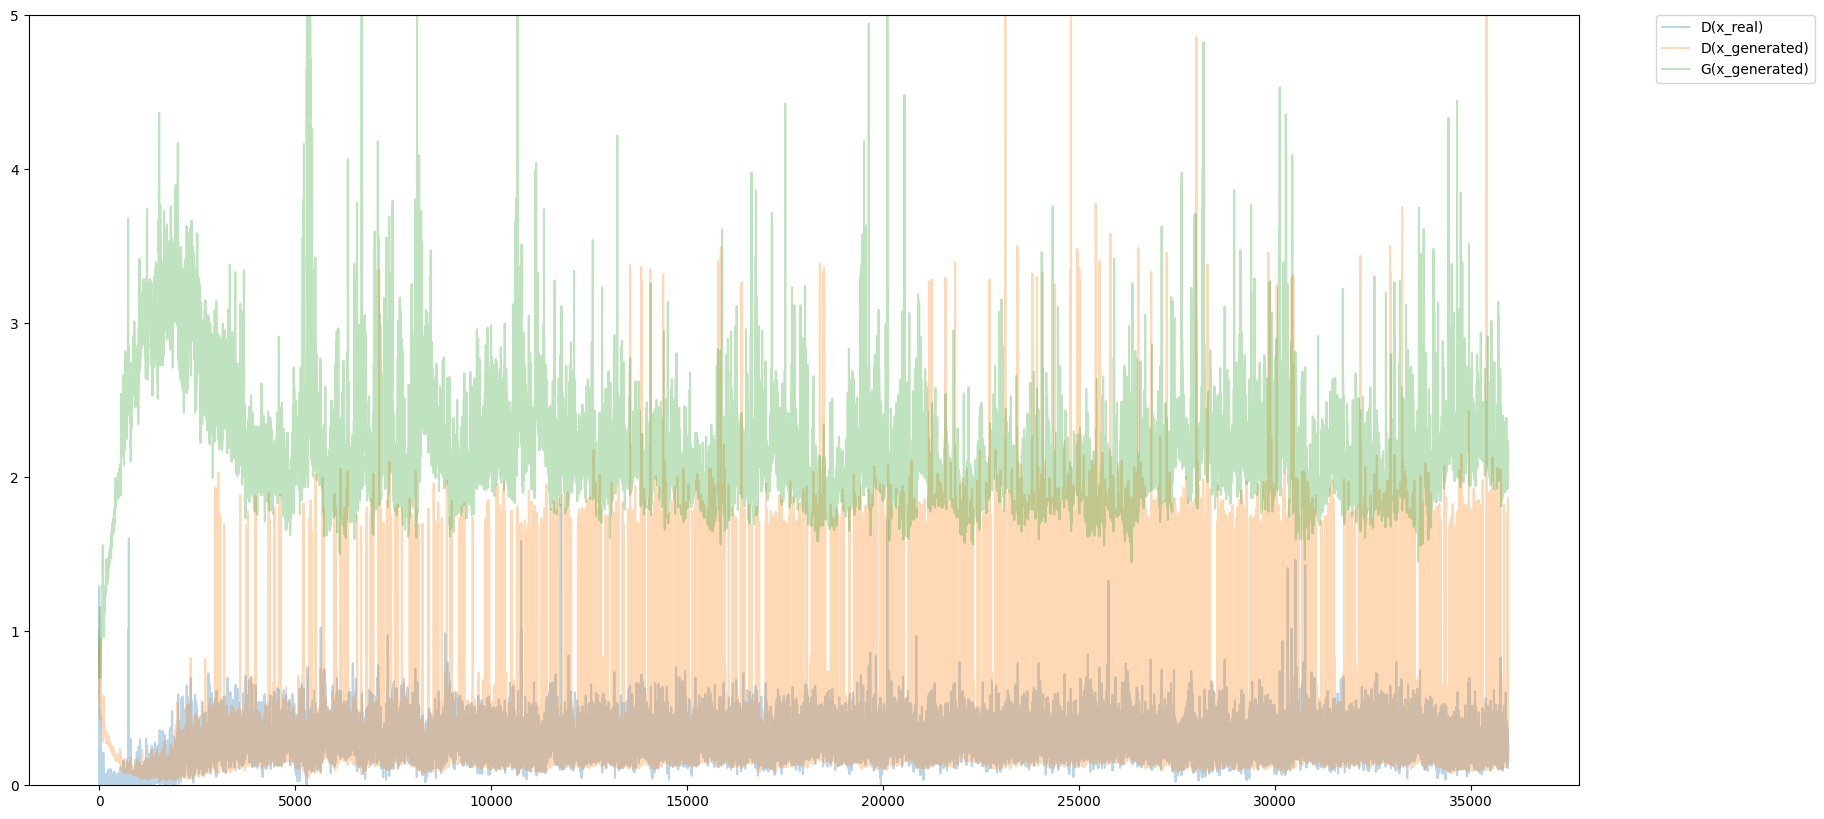

In [183]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.ylim(0,5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [219]:
trg_label = 5
check_df = data_df[data_df[yCol+'_G']==trg_label]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,2.960059,164.142012,10.207101,617.822485,58.066160,384.152367,21.505847,130.528107,3.629412,139.099112,2.211829,239.529586,3.790072,484.000000,12.308469
std,1.012457,5.484303,1.484241,114.398347,33.240787,287.624352,26.073398,206.450570,7.637641,180.814422,8.543604,299.592237,12.446505,482.376635,23.782983
min,1.000000,160.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,160.000000,10.000000,564.000000,28.425242,81.000000,2.932551,78.000000,0.666667,78.000000,0.488007,98.000000,0.492409,139.500000,0.558400
50%,2.000000,160.000000,10.000000,593.000000,50.588223,535.000000,9.852217,81.000000,1.500000,98.000000,0.923792,121.000000,1.000000,182.000000,1.500000
75%,4.000000,170.000000,10.000000,679.000000,100.000000,585.000000,29.186804,81.000000,4.242424,115.000000,1.500000,203.000000,1.818182,1158.000000,10.640481
max,4.000000,180.000000,20.000000,1257.000000,100.000000,1384.000000,100.000000,1397.000000,100.000000,1354.000000,100.000000,1336.000000,100.000000,1351.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,5.239302,148.199753,-3.701936,586.186768,42.175926,470.517090,11.322204,233.751480,6.906368,149.191132,4.811017,135.154190,-5.002748,207.457108,3.695755
std,11.642853,124.348740,12.260484,414.110565,69.095535,349.727356,31.143972,251.125381,12.479310,88.564346,15.665997,105.214394,9.871914,171.358978,16.648355
min,-45.505825,-31.811869,-34.035484,44.828773,-114.353653,-266.818451,-96.101280,14.193126,-28.261034,-73.198082,-41.490665,-83.852142,-35.698647,-188.764725,-51.824936
25%,-1.220601,60.068775,-12.076432,322.183937,-7.622005,221.545635,-9.943029,113.519547,-0.716488,94.626415,-5.137944,65.058973,-11.348938,109.293476,-6.182551
50%,5.381783,118.955894,-3.730984,458.633682,29.614818,408.399078,10.898266,148.415504,4.977005,137.361786,3.966905,119.081120,-5.578967,174.171379,3.146662
75%,12.121728,202.598236,3.748100,733.303055,78.953356,661.135361,31.232914,218.961018,12.973989,190.008396,14.026663,187.743011,0.529417,264.465759,12.794605
max,44.851444,957.033020,39.025604,3511.902588,390.699799,2300.055420,109.714127,1713.023193,63.967693,629.136536,62.105064,650.368042,36.045055,1314.329102,64.564133


In [198]:
batch_size = 64
lr = 0.01
num_epochs = 300
show_step = 25

stVal = 0

criterion = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[1:2]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')

    # 조건변수의 구간화
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = nUniq//10
    print(f'groupNum : {grNum}')

    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)
    # data_df[yCol+'_G'], cutBins = pd.cut(data_df[yCol],bins=grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)

    # 원재료코드의 숫자로의 인코드
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        data_df['phr'+str(i)].fillna(0, inplace=True)

    # 분류의 숫자로의 인코드
    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))

    # 필요없는 변수 제거
    data_df = data_df.drop(['lab_pk', yCol], axis=1)

    # batch_size 로 나눠지도록 나머지 버림
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    condition_size = grNum                                      # 조건 feature의 개수
    input_size = len(data_df.columns) - 1                       # 입력 feature의 개수
    output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
    latent_size = 100                                           # 잠재 공간의 크기
    
    discriminator = Discriminator(input_size, condition_size)
    generator = Generator(latent_size, output_size, condition_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):

        for n, (real_data,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            real_data_labels = torch.ones((batch_size, 1))
            fake_data_labels = torch.zeros((batch_size, 1))

            x = real_data[:,:-1]
            labels = real_data[:,-1:]

            """
            FOR CONDITIONAL GAN
            """
            # Encode MNIST's label's with 'one hot encoding'
            label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
            # concat real images with 'label encoded vector'
            real_data_concat = torch.cat((x, label_encoded), 1)

            # +---------------------+
            # |   train Generator   |
            # +---------------------+

            # Initialize grad
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # make fake data with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Compare result of discriminator with fake images & real labels
            # If generator deceives discriminator, g_loss will decrease
            g_loss = criterion(discriminator(fake_data_concat), real_data_labels)

            # Train generator with backpropagation
            g_loss.backward()
            g_optimizer.step()

            # +---------------------+
            # | train Discriminator |
            # +---------------------+

            # Initialize grad
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # make fake images with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Calculate fake & real loss with generated images above & real images
            fake_loss = criterion(discriminator(fake_data_concat), fake_data_labels)
            real_loss = criterion(discriminator(real_data_concat), real_data_labels)
            d_loss = (fake_loss + real_loss) / 2

            # Train discriminator with backpropagation
            # In this part, we don't train generator
            d_loss.backward()
            d_optimizer.step()

            d_performance = discriminator(real_data_concat).mean()
            g_performance = discriminator(fake_data_concat).mean()

            p_d_real_trace.append(real_loss.item())
            p_d_gen_trace.append(fake_loss.item())
            p_g_gen_trace.append(g_loss.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {d_loss:.5f}, Loss G.: {g_loss:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()

groupNum : 55
Epoch:   0 Loss D.: 0.45753, Loss G.: 1.08188, time: 0.241s
Epoch:  25 Loss D.: 0.33380, Loss G.: 1.71180, time: 12.160s
Epoch:  50 Loss D.: 0.49588, Loss G.: 1.16298, time: 12.255s
Epoch:  75 Loss D.: 1.19239, Loss G.: 1.06157, time: 12.839s
Epoch: 100 Loss D.: 0.55447, Loss G.: 0.96982, time: 15.712s
Epoch: 125 Loss D.: 0.63722, Loss G.: 0.82721, time: 16.892s
Epoch: 150 Loss D.: 1.38737, Loss G.: 0.81494, time: 16.095s
Epoch: 175 Loss D.: 2.18269, Loss G.: 0.78509, time: 16.582s
Epoch: 200 Loss D.: 0.67664, Loss G.: 0.71070, time: 17.271s
Epoch: 225 Loss D.: 0.67668, Loss G.: 0.72877, time: 16.931s
Epoch: 250 Loss D.: 2.23939, Loss G.: 0.67013, time: 16.090s
Epoch: 275 Loss D.: 0.69315, Loss G.: 0.69645, time: 16.423s


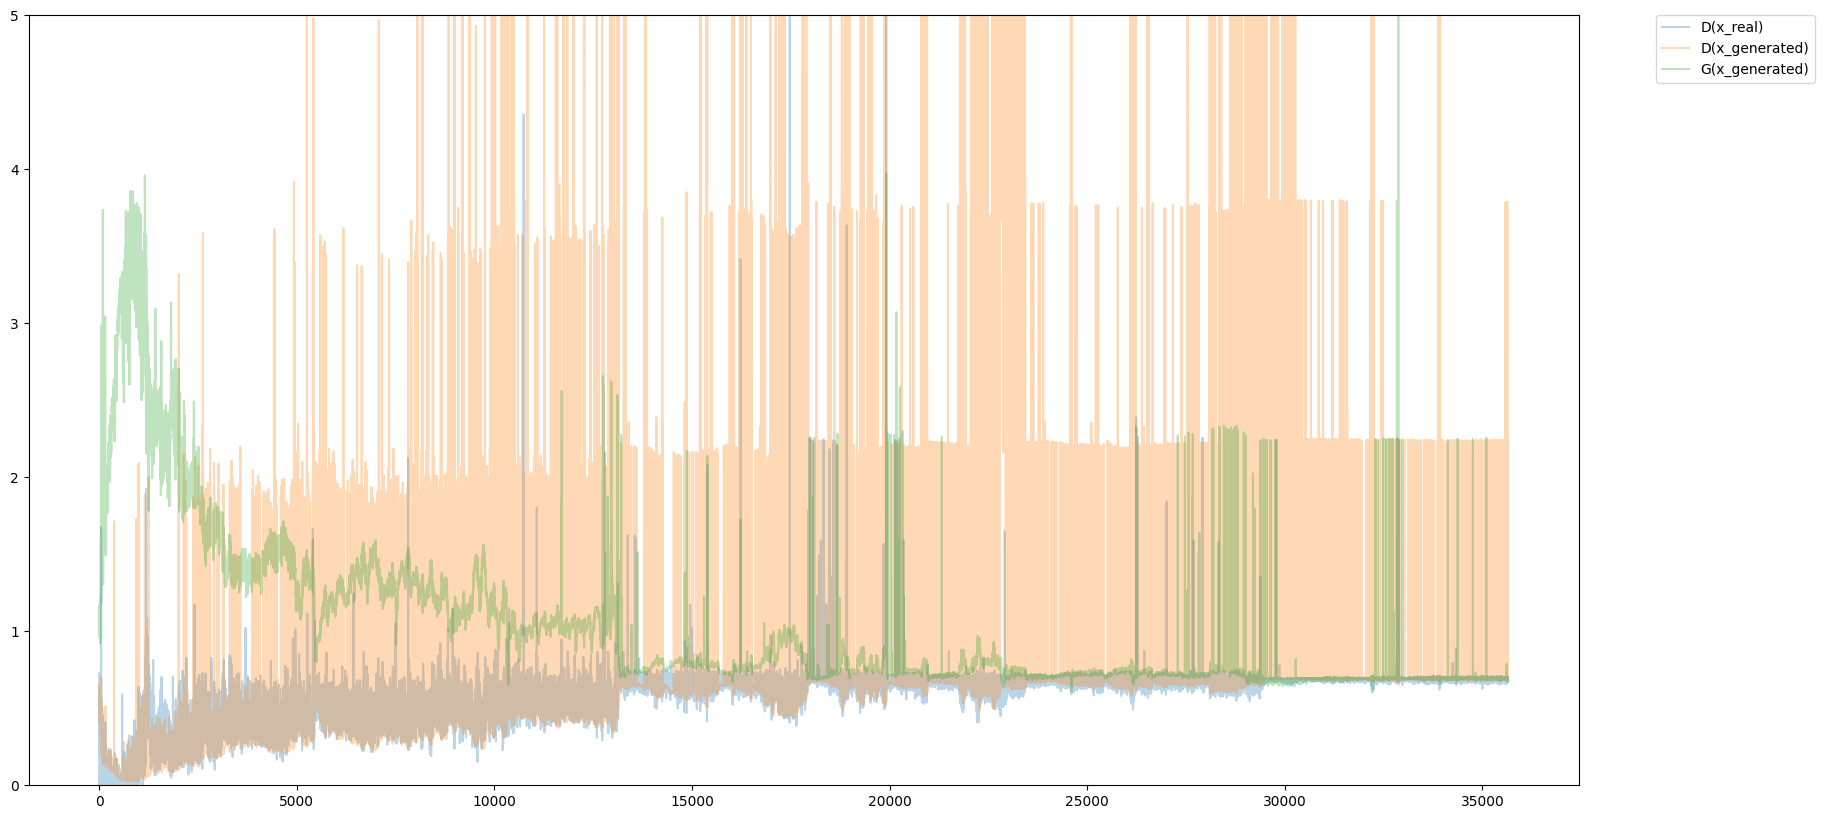

In [199]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.ylim(0,5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [215]:
trg_label = 10
check_df = data_df[data_df[yCol+'_G']==trg_label]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,2.980132,164.172185,10.099338,600.456954,56.325473,408.000000,26.501467,96.642384,3.037828,100.781457,1.092166,141.814570,1.965411,426.920530,11.029871
std,1.003130,6.669094,1.757858,119.539602,32.509125,245.979701,28.967898,75.348023,3.145778,44.433305,1.441650,135.650109,8.742875,487.804203,24.838647
min,2.000000,160.000000,5.000000,0.000000,0.000000,78.000000,0.499426,78.000000,0.149477,78.000000,0.071073,78.000000,0.071073,78.000000,0.071073
25%,2.000000,160.000000,10.000000,566.500000,29.640601,81.000000,4.000000,78.000000,0.683333,78.000000,0.378310,98.000000,0.492134,115.000000,0.630517
50%,2.000000,160.000000,10.000000,581.000000,50.397878,556.000000,15.915119,81.000000,1.795332,98.000000,0.763359,121.000000,0.819672,142.000000,1.146132
75%,4.000000,170.000000,10.000000,675.000000,99.504950,566.000000,35.502834,81.000000,4.310345,98.000000,1.237113,142.000000,1.333333,419.000000,2.857143
max,4.000000,180.000000,15.000000,740.000000,100.000000,756.000000,100.000000,734.000000,16.666667,419.000000,11.666667,1265.000000,100.000000,1382.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,-34.808735,127.001602,13.723177,448.253723,-9.561215,377.140198,-100.883659,148.846985,-20.628820,224.602341,13.946338,172.143600,17.661026,370.638306,46.064182
std,75.199966,119.674240,76.913132,264.148926,85.123444,328.127869,124.514351,169.375336,85.620636,247.624054,53.027748,220.230408,60.700634,281.962372,77.928253
min,-198.798340,-218.556061,-222.746201,-102.523758,-255.128830,-675.010315,-417.139069,-356.007324,-255.023361,-244.805527,-116.011909,-351.672180,-109.508469,-308.734833,-159.044312
25%,-90.089817,47.632133,-38.245058,271.852371,-71.955517,136.704262,-186.158157,33.534189,-79.194080,41.345959,-17.811939,19.386740,-19.996049,168.294029,-0.596966
50%,-41.180214,132.871124,16.591257,408.264557,-12.848492,346.785553,-107.537399,143.448456,-5.552504,222.416504,11.430079,156.297623,9.328079,338.590942,45.898983
75%,17.522262,206.631485,71.221115,613.869019,55.507427,573.089813,-28.525495,251.666046,38.751699,369.884842,46.821920,310.164352,49.880684,572.837128,94.088707
max,151.234192,433.670959,223.022049,1225.015259,212.509659,1130.341309,230.204010,594.480652,206.418289,929.869812,206.294464,1002.719482,247.057678,1103.091797,312.312592
